In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

# Verbinde mit der SQLite-Datenbank
conn = sqlite3.connect('derstandard.db')

# Relevante Tabellen laden
articles_df = pd.read_sql_query("SELECT * FROM Articles", conn)
sentiment_df = pd.read_sql_query("SELECT * FROM Article_Sentiment", conn)
keywords_df = pd.read_sql_query("""
                                SELECT ak.articleID, k.keyword 
                                FROM Article_Keywords ak 
                                JOIN Keywords k ON ak.keywordID = k.keywordID
                                """, conn)

# Verbindung zur Datenbank schließen
conn.close()

# Definiere die relevanten Parteien, die in der Keywords Tabelle vorkommen können
parties = ['ÖVP', 'SPÖ', 'FPÖ', 'Grüne', 'NEOS']

# Filtere die Keywords-Tabelle, um nur die Einträge für die relevanten Parteien zu behalten
party_keywords_df = keywords_df[keywords_df['keyword'].isin(parties)]

# Gruppiere nach articleID, um sicherzustellen, dass nur Artikel mit genau einer Partei übrig bleiben
# Filtere alle Artikel heraus, die mehr als ein Partei-Keyword haben
party_counts_df = party_keywords_df.groupby('articleID').agg(
    party_count=('keyword', 'count'),
    Partei=('keyword', 'first')  
).reset_index()

# Filtere nur die Artikel, in denen genau eine Partei genannt wird
single_party_articles_df = party_counts_df[party_counts_df['party_count'] == 1]

# Artikel und Sentiment-Daten zusammenführen
df = pd.merge(articles_df, sentiment_df, on='articleID')
df = pd.merge(df, single_party_articles_df[['articleID', 'Partei']], on='articleID')

# Datumsspalte konvertieren
df['datetime'] = pd.to_datetime(df['datetime'])

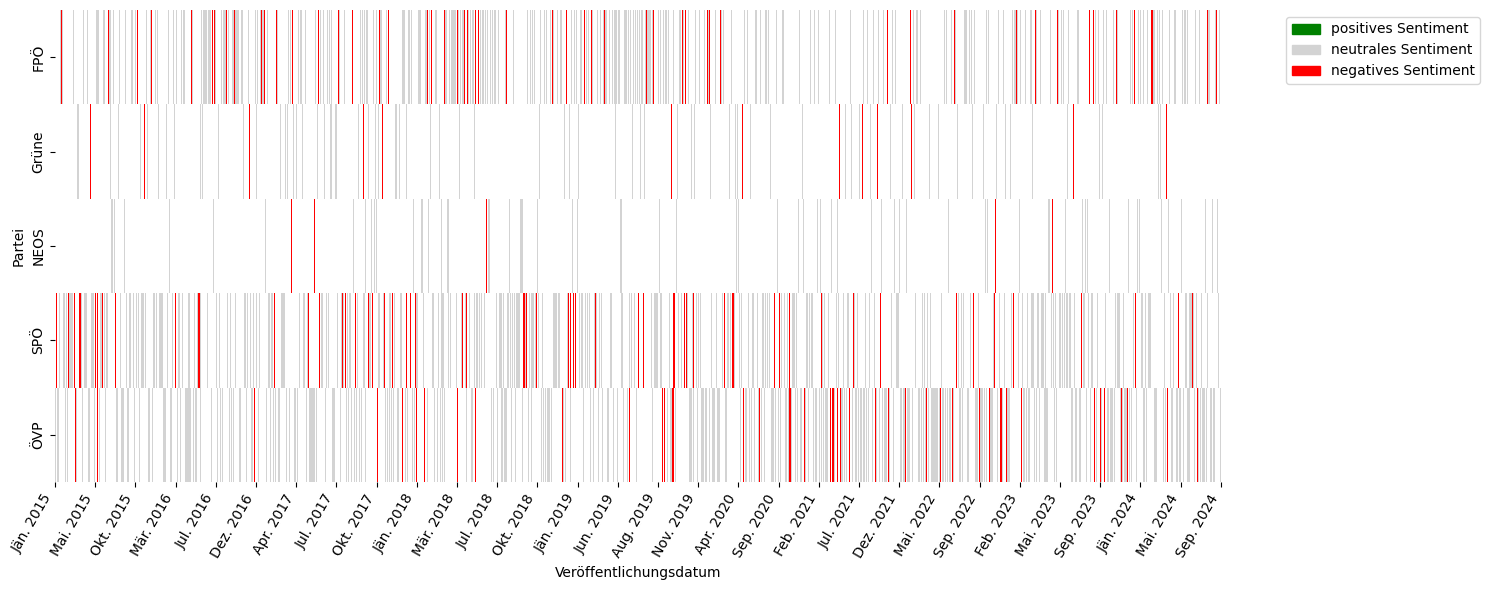

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

# Gruppiere die Daten nach Veröffentlichungsdatum (Stunde) und Partei
grouped_df = df.groupby([pd.Grouper(key='datetime', freq='h'), 'Partei']).agg(
    n=('articleID', 'count'),
    mean_sentiment=('sentiment_value', 'mean')
).reset_index()

# Funktion zur Klassifizierung des Sentiments
def assign_sentiment_category(sum_sentiment):
    if sum_sentiment > 0.5:
        return 'positiv'
    elif sum_sentiment < -0.5:
        return 'negativ'
    else:
        return 'neutral'

# Sentiment-Kategorie zuweisen
grouped_df['sentiment'] = grouped_df['mean_sentiment'].apply(assign_sentiment_category)

# Sentiment-Kategorien in numerische Werte umwandeln
sentiment_mapping = {'negativ': -1, 'neutral': 0, 'positiv': 1}
grouped_df['sentiment_numeric'] = grouped_df['sentiment'].map(sentiment_mapping)

# Pivot-Tabelle erstellen (Partei vs. Veröffentlichungsdatum)
pivot_df = grouped_df.pivot(index='Partei', columns='datetime', values='mean_sentiment')

# Spalten (Daten) sortieren
pivot_df = pivot_df.sort_index(axis=1)

# Benutzerdefinierte Farbkarte erstellen
cmap = mcolors.ListedColormap(['red', 'lightgrey', 'green'])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# datetime to str
formatted_dates = pivot_df.columns.strftime('%b. %Y')

# Plot erstellen
plt.figure(figsize=(15, 6))
ax = sns.heatmap(pivot_df, cmap=cmap, norm=norm, cbar=False, linecolor='none')

# x-Achsen-Beschriftungen rotieren
plt.xticks(rotation=60, ha='right')

# Indizes für die xticks auswählen
num_years = pivot_df.columns.max().year - pivot_df.columns.min().year + 1
xticks_positions = np.linspace(0, len(formatted_dates) - 1, num=3 * num_years, dtype=int)
xticks_labels = [formatted_dates[i] for i in xticks_positions]

# xticks setzen
plt.gca().set_xticks(xticks_positions)
plt.gca().set_xticklabels(xticks_labels, rotation=60, ha='right')

# Achsenbeschriftungen 
plt.xlabel('Veröffentlichungsdatum')

# Legende für Sentiment erstellen
sentiment_handles = [
    mpatches.Patch(color='green', label='positives Sentiment'),
    mpatches.Patch(color='lightgrey', label='neutrales Sentiment'),
    mpatches.Patch(color='red', label='negatives Sentiment')
]

# Aktuelle Achsen holen
ax = plt.gca()

# Liste der Daten und Parteien holen
dates = pivot_df.columns 
parties = pivot_df.index.values

# Mapping von Partei zu y-Position erstellen
party_to_ypos = {party: i + 0.5 for i, party in enumerate(parties)} 

# Legende für Regierungskoalitionen erstellen
government_handles = []


# Beide Legenden kombinieren
handles = sentiment_handles + government_handles
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


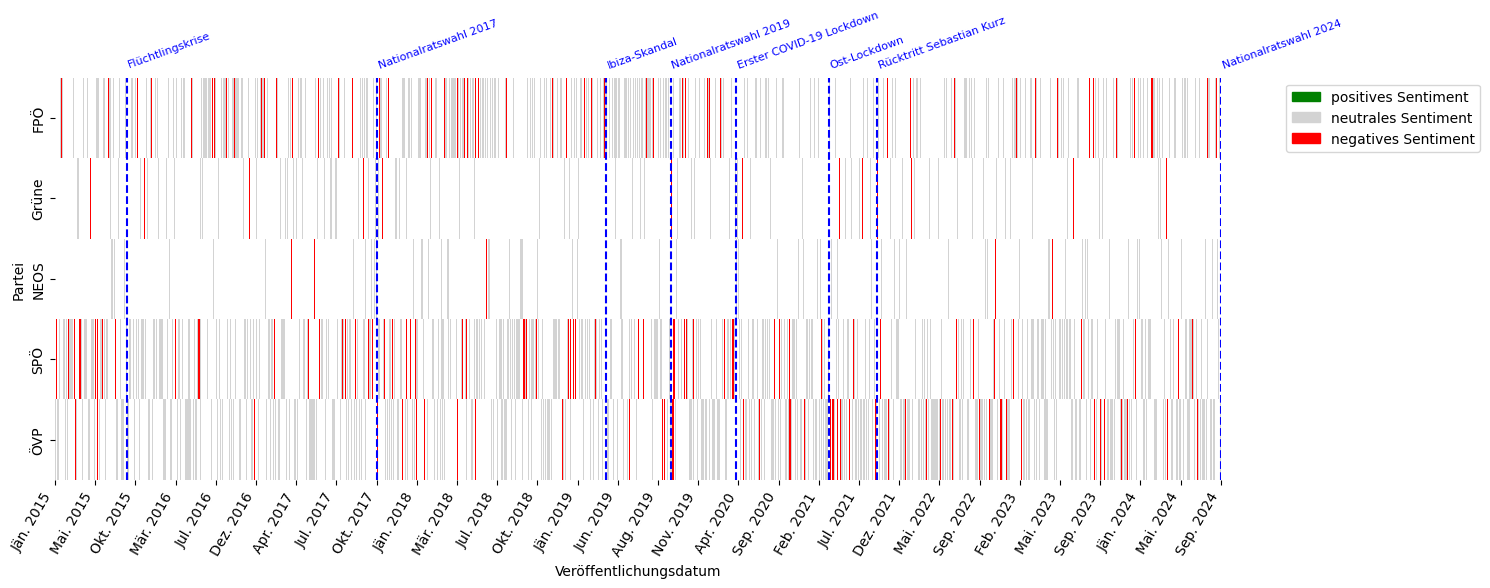

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

# Gruppiere die Daten nach Veröffentlichungsdatum (Stunde) und Partei
grouped_df = df.groupby([pd.Grouper(key='datetime', freq='h'), 'Partei']).agg(
    n=('articleID', 'count'),
    mean_sentiment=('sentiment_value', 'mean')
).reset_index()

# Funktion zur Klassifizierung des Sentiments
def assign_sentiment_category(sum_sentiment):
    if sum_sentiment > 0.5:
        return 'positiv'
    elif sum_sentiment < -0.5:
        return 'negativ'
    else:
        return 'neutral'

# Sentiment-Kategorie zuweisen
grouped_df['sentiment'] = grouped_df['mean_sentiment'].apply(assign_sentiment_category)

# Sentiment-Kategorien in numerische Werte umwandeln
sentiment_mapping = {'negativ': -1, 'neutral': 0, 'positiv': 1}
grouped_df['sentiment_numeric'] = grouped_df['sentiment'].map(sentiment_mapping)

# Pivot-Tabelle erstellen (Partei vs. Veröffentlichungsdatum)
pivot_df = grouped_df.pivot(index='Partei', columns='datetime', values='mean_sentiment')

# Spalten (Daten) sortieren
pivot_df = pivot_df.sort_index(axis=1)

# Benutzerdefinierte Farbkarte erstellen
cmap = mcolors.ListedColormap(['red', 'lightgrey', 'green'])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# datetime to str
formatted_dates = pivot_df.columns.strftime('%b. %Y')

# Plot erstellen
plt.figure(figsize=(15, 6))
ax = sns.heatmap(pivot_df, cmap=cmap, norm=norm, cbar=False, linecolor='none')

# x-Achsen-Beschriftungen rotieren
plt.xticks(rotation=60, ha='right')

# Indizes für die xticks auswählen
num_years = pivot_df.columns.max().year - pivot_df.columns.min().year + 1
xticks_positions = np.linspace(0, len(formatted_dates) - 1, num=3 * num_years, dtype=int)
xticks_labels = [formatted_dates[i] for i in xticks_positions]

# xticks setzen
plt.gca().set_xticks(xticks_positions)
plt.gca().set_xticklabels(xticks_labels, rotation=60, ha='right')

# Achsenbeschriftungen 
plt.xlabel('Veröffentlichungsdatum')

# Legende für Sentiment erstellen
sentiment_handles = [
    mpatches.Patch(color='green', label='positives Sentiment'),
    mpatches.Patch(color='lightgrey', label='neutrales Sentiment'),
    mpatches.Patch(color='red', label='negatives Sentiment')
]

# Wichtige Ereignisse definieren
events = [
    ('2015-09-01', 'Flüchtlingskrise'),
    ('2017-10-15', 'Nationalratswahl 2017'),
    ('2019-05-17', 'Ibiza-Skandal'),
    ('2019-09-29', 'Nationalratswahl 2019'),
    ('2020-03-16', 'Erster COVID-19 Lockdown'),
    #('2020-11-17', 'Zweiter COVID-19 Lockdown'),
    #('2020-12-26', 'Dritter COVID-19 Lockdown'),
    ('2021-04-01', 'Ost-Lockdown'),
    #('2021-11-22', 'Vierter COVID-19 Lockdown'),
    #('2021-12-12', 'Ende des vierten Lockdowns'),
    ('2021-10-11', 'Rücktritt Sebastian Kurz'),
    ('2024-09-29', 'Nationalratswahl 2024')
]

# Aktuelle Achsen holen
ax = plt.gca()

# Liste der Daten und Parteien holen
dates = pivot_df.columns 
parties = pivot_df.index.values

# Mapping von Partei zu y-Position erstellen
party_to_ypos = {party: i + 0.5 for i, party in enumerate(parties)} 

# Legende für Regierungskoalitionen erstellen
government_handles = []

# Wichtige Ereignisse markieren
for date_str, event_name in events:
    date = pd.to_datetime(date_str)
    x_pos = np.searchsorted(dates, date)
    # Sicherstellen, dass die Position innerhalb des Bereichs liegt
    if 0 <= x_pos <= len(dates):
        ax.axvline(x=x_pos, color='blue', linestyle='--')
        ax.text(
            x=x_pos,
            y=-0.1,
            s=event_name,
            rotation=20,
            verticalalignment='bottom',
            fontsize=8,
            color='blue'
        )

# Beide Legenden kombinieren
handles = sentiment_handles + government_handles
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


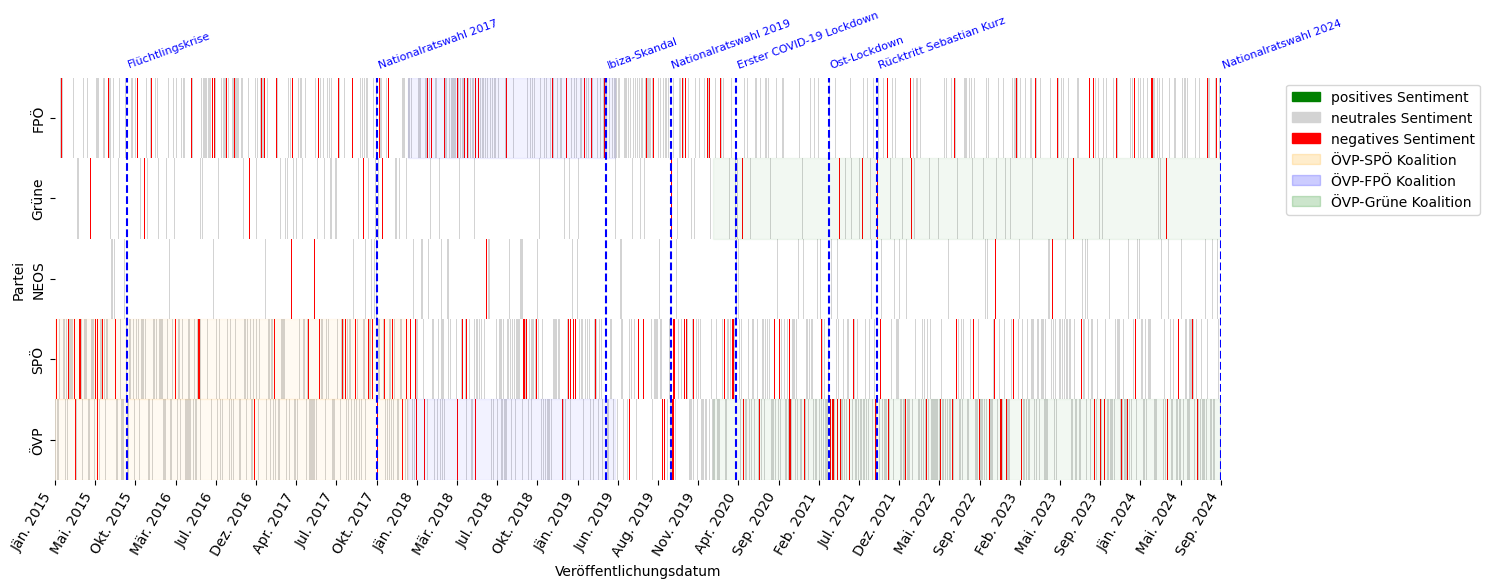

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

# Gruppiere die Daten nach Veröffentlichungsdatum (Stunde) und Partei
grouped_df = df.groupby([pd.Grouper(key='datetime', freq='h'), 'Partei']).agg(
    n=('articleID', 'count'),
    mean_sentiment=('sentiment_value', 'mean')
).reset_index()

# Funktion zur Klassifizierung des Sentiments
def assign_sentiment_category(sum_sentiment):
    if sum_sentiment > 0.5:
        return 'positiv'
    elif sum_sentiment < -0.5:
        return 'negativ'
    else:
        return 'neutral'

# Sentiment-Kategorie zuweisen
grouped_df['sentiment'] = grouped_df['mean_sentiment'].apply(assign_sentiment_category)

# Sentiment-Kategorien in numerische Werte umwandeln
sentiment_mapping = {'negativ': -1, 'neutral': 0, 'positiv': 1}
grouped_df['sentiment_numeric'] = grouped_df['sentiment'].map(sentiment_mapping)

# Pivot-Tabelle erstellen (Partei vs. Veröffentlichungsdatum)
pivot_df = grouped_df.pivot(index='Partei', columns='datetime', values='mean_sentiment')

# Spalten (Daten) sortieren
pivot_df = pivot_df.sort_index(axis=1)

# Benutzerdefinierte Farbkarte erstellen
cmap = mcolors.ListedColormap(['red', 'lightgrey', 'green'])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# datetime to str
formatted_dates = pivot_df.columns.strftime('%b. %Y')

# Plot erstellen
plt.figure(figsize=(15, 6))
ax = sns.heatmap(pivot_df, cmap=cmap, norm=norm, cbar=False, linecolor='none')

# x-Achsen-Beschriftungen rotieren
plt.xticks(rotation=60, ha='right')

# Indizes für die xticks auswählen
num_years = pivot_df.columns.max().year - pivot_df.columns.min().year + 1
xticks_positions = np.linspace(0, len(formatted_dates) - 1, num=3 * num_years, dtype=int)
xticks_labels = [formatted_dates[i] for i in xticks_positions]

# xticks setzen
plt.gca().set_xticks(xticks_positions)
plt.gca().set_xticklabels(xticks_labels, rotation=60, ha='right')

# Achsenbeschriftung
plt.xlabel('Veröffentlichungsdatum')

# Legende für Sentiment erstellen
sentiment_handles = [
    mpatches.Patch(color='green', label='positives Sentiment'),
    mpatches.Patch(color='lightgrey', label='neutrales Sentiment'),
    mpatches.Patch(color='red', label='negatives Sentiment')
]

# Regierungskoalitionen mit unterschiedlichen Farben
governments = [
    {
        'name': 'ÖVP-SPÖ Koalition',
        'parties': ['ÖVP', 'SPÖ'],
        'start': '2013-12-16',
        'end': '2017-12-18',
        'color': 'orange'
    },
    {
        'name': 'ÖVP-FPÖ Koalition',
        'parties': ['ÖVP', 'FPÖ'],
        'start': '2017-12-18',
        'end': '2019-05-28',
        'color': 'blue'
    },
    {
        'name': 'ÖVP-Grüne Koalition',
        'parties': ['ÖVP', 'Grüne'],
        'start': '2020-01-07',
        'end': '2025-09-01',
        'color': 'green'
    }
]

# Wichtige Ereignisse definieren
events = [
    ('2015-09-01', 'Flüchtlingskrise'),
    ('2017-10-15', 'Nationalratswahl 2017'),
    ('2019-05-17', 'Ibiza-Skandal'),
    ('2019-09-29', 'Nationalratswahl 2019'),
    ('2020-03-16', 'Erster COVID-19 Lockdown'),
    #('2020-11-17', 'Zweiter COVID-19 Lockdown'),
    #('2020-12-26', 'Dritter COVID-19 Lockdown'),
    ('2021-04-01', 'Ost-Lockdown'),
    #('2021-11-22', 'Vierter COVID-19 Lockdown'),
    #('2021-12-12', 'Ende des vierten Lockdowns'),
    ('2021-10-11', 'Rücktritt Sebastian Kurz'),
    ('2024-09-29', 'Nationalratswahl 2024')
]

# Aktuelle Achsen holen
ax = plt.gca()

# Liste der Daten und Parteien holen
dates = pivot_df.columns 
parties = pivot_df.index.values

# Mapping von Partei zu y-Position erstellen
party_to_ypos = {party: i + 0.5 for i, party in enumerate(parties)} 

# Legende für Regierungskoalitionen erstellen
government_handles = []

# Regierungszeiten schattieren
for gov in governments:
    gov_name = gov['name']
    gov_parties = gov['parties']
    start_date = pd.to_datetime(gov['start'])
    end_date = pd.to_datetime(gov['end'])
    color = gov['color']
    
    # Für die Legende (nur einmal pro Regierung)
    government_handles.append(mpatches.Patch(color=color, alpha=0.2, label=gov_name))
    
    # x-Positionen finden
    start_x = np.searchsorted(dates, start_date)
    end_x = np.searchsorted(dates, end_date)
    # Sicherstellen, dass die Positionen innerhalb des Bereichs liegen
    start_x = max(start_x, 0)
    end_x = min(end_x, len(dates))
    
    for party in gov_parties:
        if party in party_to_ypos:
            y_pos = party_to_ypos[party]
            # Rechteck zeichnen
            rect = mpatches.Rectangle(
                (start_x, y_pos - 0.5),  # -0.5 um die gesamte Zelle abzudecken
                width=end_x - start_x,
                height=1,
                color=color,
                alpha=0.05
            )
            ax.add_patch(rect)

# Wichtige Ereignisse markieren
for date_str, event_name in events:
    date = pd.to_datetime(date_str)
    x_pos = np.searchsorted(dates, date)
    # Sicherstellen, dass die Position innerhalb des Bereichs liegt
    if 0 <= x_pos <= len(dates):
        ax.axvline(x=x_pos, color='blue', linestyle='--')
        ax.text(
            x=x_pos,
            y=-0.1,
            s=event_name,
            rotation=20,
            verticalalignment='bottom',
            fontsize=8,
            color='blue'
        )

# Beide Legenden kombinieren
handles = sentiment_handles + government_handles
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### Erweiterungen

- Weitere Medienhäuser?
- User-Kommentare?
- Emotionen?
- Ambivalente Artikel? "Wirklich neutrale" Artikel, oder unterschiedliche Sentiments je nach Paragraph.